### Тестирование психического здоровья

В данных содержатся ответы добровольцев на тесты на наличие депрессии, особенности характера, знание редких слов, а также их персональные данные.

В ходе работы с данными выполнены следующие задачи:

- [ ] очистка данных от выбросов и ошибок
- [ ] простая модель оценки уровней депрессии, тревоги и стресса на основе теста DASS
- [ ] выделение зависимости между скоростью ответов на тест DASS и очерёдностью вопросов
- [ ] поиск наиболее и наименее типичных признаков депрессии и тревоги
- [ ] поиск слов, сильнее всего свидетельствующих об общем уровне грамотности
- [ ] рассмотрение связи между личными качествами, образованием, размером семьи и уровнями депрессии, тревоги и стресса
- [ ] сравнение психического состояния групп похожих людей

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [18]:
file1=pd.read_csv('data.csv', sep='\t')

### Описание данных

**1. Тест DASS** - включает в себя 42 вопроса, каждый из которых ориентирован на диагностику уровня депрессии, тревоги или стресса. В каждом вопросе дано утверждение и предлагается оценить, насколько часто описанное состояние возникает у тестируемого.

**2. Тест TIPI** - предложено 10 черт характера, для каждого необходимо оценить, как сильно оно характерно для тестируемого.

**3. Тест VCL** - необходимо отметить среди 16 слов те, значение которых участник точно знает

**4. Персональные данные** (возраст, уровень образования, данные об устройстве, с которого проходили тест, и др.)

### Очистка данных

##### Проверим наличие пропущенных данных (датасет слишком большой чтобы использовать info())

In [3]:
file1.shape

(39775, 171)

In [4]:
pd.options.display.max_info_columns

100

In [5]:
n=file1.shape[0]
for col in file1.columns:
    a=file1[col].isnull().value_counts()[False]
    if a!=n:
        print(col, n-a)

country 2
major 11403


In [19]:
file1['major']=file1['major'].fillna('no')
file1['country']=file1['country'].fillna('no')

### Выбросы и опечатки

#### Тест DASS

***Q_i_A*** - ответ на i вопрос от 1 до 4, где 1 - никогда, 4 - очень часто или постоянно. Вопросы предлагаются в случайном порядке и делятся на 3 группы, измеряющие уровень стресса, тревоги и депрессии. Вопросы из каждой группы:

стресс - 1,6,8,11,12,14,18,

тревога - 2,4,7,9, 15,19,20

депрессия - 3,5,10,13,16,17,21


***Q_i_E*** - количество милисекунд, потраченных на ответ на i вопрос

***Q_i_I*** - порядковый номер i вопроса для данного участника

***introelapse*** - время в секундах, потраченное на начальную страницу

***testelapse*** - время в секундах, потраченное на весь тест	

***surveyelapse***	- время, потраченное на вопросы о личных данных и другие тесты


In [7]:
def find_err(df, values):
    """
    Получает на вход датафрейм и список возможных значений
    Возвращает список индексов элементов, у которых хотя бы один из признаков 
    равен недопустимому значению
    """
    bad_ans=[]
    for col in df.columns:
        bad_ans+=(list(df[~df[col].isin(values)].index))
    return bad_ans

In [8]:
find_err(file1[['Q'+str(i)+'A' for i in range(1,43)]], range(1,5))

[]

In [11]:
qe_names=['Q'+str(_) + 'E' for _ in range(1,43)]

In [23]:
#Переведём время ответов в секунды
file1[qe_names]=file1[['Q'+str(i)+'E' for i in range(1,43)]]/1000

In [12]:
file1[qe_names].describe() #есть отрицательные значения - поменяем на противоположные
#есть явные выбросы

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33E,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,...,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,6.970591,5.332376,7.426446,7.128728,5.919306,5.724097,9.776971,4.444627,18.330829,9.157494,...,5.272239,4.871684,14.105871,4.335748,6.811023,5.838114,8.472124,10.274100,5.540696,8.300695
std,86.705132,26.513611,158.702353,75.984858,64.282067,50.195831,442.758756,22.916182,1409.724444,418.635469,...,51.466986,108.623401,376.000379,30.703420,76.601331,301.126024,168.614116,320.856859,59.782867,77.650779
min,0.180000,0.176000,-10.814000,0.176000,0.178000,0.178000,0.178000,0.179000,0.177000,-19.695000,...,0.179000,-1.615000,0.183000,0.178000,-0.165000,-8.921000,-0.144000,0.178000,-0.159000,0.178000
25%,2.664000,2.477000,2.857000,2.949000,2.327000,2.369000,2.641500,2.104500,4.218000,2.427000,...,2.162000,1.922000,4.317500,1.681000,2.883000,1.897000,2.130500,3.393500,2.237000,3.070000
50%,3.609000,3.511000,3.898000,4.258000,3.237000,3.248000,3.702000,2.871000,6.139000,3.375000,...,2.993000,2.653000,6.499000,2.254000,4.054000,2.602000,2.930000,4.629000,3.052000,4.373000
75%,5.358000,5.216000,5.766000,6.285000,4.849000,4.788000,5.362000,4.239500,9.245000,5.027000,...,4.608000,4.003500,10.388000,3.484000,5.924000,3.934500,4.940000,6.733000,4.518000,6.681000
max,12102.282000,2161.057000,28582.689000,9488.330000,9467.497000,5426.858000,74124.488000,2103.626000,279772.213000,74471.124000,...,8658.903000,21328.973000,72970.668000,4133.123000,12710.289000,59401.008000,31773.217000,56297.555000,8021.110000,7750.098000


In [10]:
file1['testelapse'].describe() #нет отрицательных значений, есть явные выбросы

count    3.977500e+04
mean     2.684843e+03
std      1.482418e+05
min      1.200000e+01
25%      1.650000e+02
50%      2.130000e+02
75%      2.960000e+02
max      2.082972e+07
Name: testelapse, dtype: float64

In [27]:
(file1['testelapse']-file1[qe_names].sum(axis=1)).describe()

count    3.977500e+04
mean     2.364812e+03
std      1.482231e+05
min     -2.295600e+01
25%      1.031000e+00
50%      2.237000e+00
75%      1.201950e+01
max      2.082853e+07
dtype: float64

testelapse - суммарное время, потраченное каждым участником на опрос DASS, видно, что далеко не всегда это соответствует реальности

Обработаем данные QE

In [28]:
for col in qe_names:
    file1.loc[file1[col]<0, col]*=-1

Маловероятно, что люди тратили меньше секунды на прочтение вопросов и выбор ответа, даже если человек просто наугад ставил ответы, не читая вопросы. Допустим, время должно быть в 10 раз больше (хотя бы секунда)

In [29]:
for col in qe_names:
    mask=(file1[col]<1)
    file1.loc[mask,col]*=10

Среди значений QE есть и очень большие величины порядка 10^5 секунд (27 часов на один вопрос), что вряд ли возможно. Так как не указано, что тест можно было проходить отвлекаясь в течение недели, предполагаем, что тест проходился полностью за один раз. Так как большинство тратило несколько секунд на каждый вопрос, но кто-то возможно отвечал существенно медленнее или отвлекался, ограничим время ответов 100 секундами

In [30]:
def dec_time(data):
    if data<100: return data
    else: return dec_time(data/10)

In [31]:
for col in qe_names:
    file1[col]=file1[col].apply(dec_time)

In [32]:
file1[qe_names].describe()

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33E,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,...,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,5.483691,4.872191,5.531221,5.771915,4.844152,4.703867,5.070244,4.077815,8.504698,4.871151,...,4.462093,3.992915,9.551248,3.891542,5.605781,3.870153,6.433091,6.372881,4.739526,6.400569
std,6.830208,5.299667,6.131977,6.217228,6.177413,5.616568,5.734056,4.711599,8.597437,5.805801,...,5.410820,5.006681,10.236173,5.442053,6.273624,4.659465,9.877015,6.809826,6.092162,7.421336
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.004000,1.000000,...,1.000000,1.000000,1.002000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.003000
25%,2.696000,2.522000,2.900000,3.000000,2.367000,2.407000,2.684000,2.143000,4.286000,2.468500,...,2.199000,1.964000,4.382000,1.728000,2.931000,1.935000,2.162000,3.435000,2.283000,3.128000
50%,3.645000,3.560000,3.947000,4.307000,3.282000,3.298000,3.744000,2.921000,6.194000,3.417000,...,3.043000,2.704000,6.550000,2.316000,4.101000,2.655000,2.977000,4.676000,3.104000,4.429000
75%,5.416000,5.312000,5.862000,6.358000,4.949500,4.886000,5.440000,4.326000,9.264500,5.100000,...,4.704000,4.124000,10.381000,3.667000,5.997000,4.040000,5.085000,6.806500,4.628000,6.762000
max,99.846000,95.711000,98.807000,99.028000,98.138000,96.163000,99.515000,99.603000,99.776000,99.959000,...,99.591000,98.970000,99.062000,96.684000,99.926000,98.914000,99.470000,99.297000,99.912800,99.991000


Обновим testelapse

In [33]:
file1['testelapse']=file1[qe_names].sum(axis=1)

In [34]:
file1['introelapse'].describe()

count    3.977500e+04
mean     2.432594e+03
std      1.383138e+05
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      2.000000e+01
max      2.082974e+07
Name: introelapse, dtype: float64

В introelapse есть выбросы, обработаем их также, как и признаки QE

In [35]:
file1['introelapse']=file1['introelapse'].apply(dec_time)

<AxesSubplot:xlabel='introelapse'>

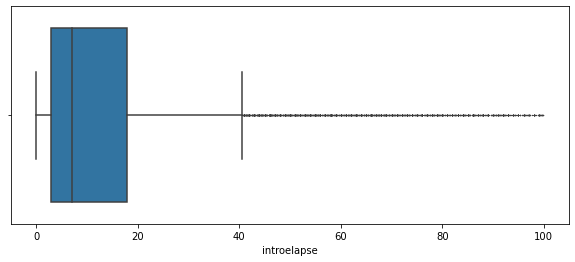

In [36]:
fig=plt.figure(figsize=(10,4))
sns.boxplot(data=file1, x='introelapse',fliersize=0.5)

100 секунд - вполне допустимое время, чтобы потратить на начальную страницу тестирования (в принципе, большие значения тоже допустимы, но считаем их выбросами из-за редкости таких случаев)

In [37]:
file1['surveyelapse'].describe()

count    3.977500e+04
mean     4.673672e+03
std      1.842179e+05
min      1.000000e+00
25%      1.450000e+02
50%      1.860000e+02
75%      2.480000e+02
max      2.082845e+07
Name: surveyelapse, dtype: float64

Ситуация для surveyelapse аналогична introelapse

In [38]:
file1['surveyelapse']=file1['surveyelapse'].apply(dec_time)

<AxesSubplot:xlabel='surveyelapse'>

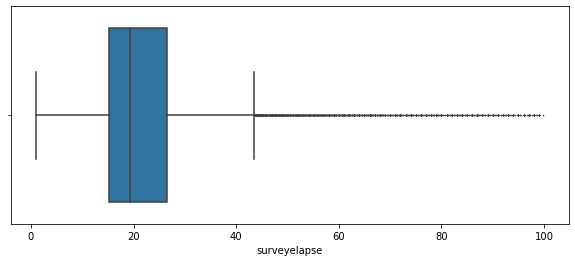

In [39]:
fig=plt.figure(figsize=(10,4))
sns.boxplot(data=file1, x='surveyelapse',fliersize=0.5)

In [40]:
q_i=['Q'+str(i)+'I' for i in range(1,43)]

In [41]:
find_err(file1[q_i], range(1,43))

[]

В признаках Q_i_I нет ошибочных значений

In [42]:
aa=[]
for i in range(file1.shape[0]):
    a=len(file1.iloc[i][q_i].unique())
    if a!=42: aa.append(a)
aa

[]

Для каждого i Q_j_I - очерёдность, в которой предлагались вопросы, то есть для каждого испытуемого они должны не повторяться и соответствовать величинам от 1 до 42

#### Тест TIPI

Набор ответов на тест TIPI - 10 утверждений, предлагается оценить, насколько учатник согласен с каждым из них, по шкале от 1 - абсолютно не согласен, 7 - абсолютно согласен


In [43]:
bad_ans=find_err(file1[['TIPI'+str(i) for i in range(1,11)]], range(1,8))

In [44]:
[file1.loc[bad_ans,'TIPI'+str(i) ].unique()for i in range(1,11)]

[array([0, 6, 5, 1, 2, 3, 4, 7], dtype=int64),
 array([0, 3, 1, 7, 6, 4, 2, 5], dtype=int64),
 array([0, 7, 6, 2, 5, 3, 4, 1], dtype=int64),
 array([0, 7, 6, 1, 2, 5, 4, 3], dtype=int64),
 array([0, 1, 6, 2, 5, 4, 7, 3], dtype=int64),
 array([0, 7, 6, 1, 4, 5, 3, 2], dtype=int64),
 array([0, 5, 1, 7, 6, 4, 2, 3], dtype=int64),
 array([0, 5, 1, 2, 6, 4, 7, 3], dtype=int64),
 array([0, 3, 7, 1, 4, 5, 2, 6], dtype=int64),
 array([0, 7, 6, 5, 1, 4, 2, 3], dtype=int64)]

In [46]:
file1.loc[bad_ans[:5], ['TIPI'+str(i) for i in range(1,11)]]

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
108,0,0,0,0,0,0,0,0,0,0
524,0,0,0,7,1,0,0,0,0,0
532,0,0,0,0,0,0,0,0,0,7
862,0,0,0,0,0,7,0,0,0,0
1281,0,0,0,7,0,7,0,0,0,0


Есть значения ответов - 0, что недопустимо, будем считать, что ответ пропущен. В некоторых случаях это может быть ошибкой и необходимое значение можно попробовать восстановить по имеющимся ответам человека, но для некоторых участников существенная доля ответов пропущена и это сделать невозможно, поэтому удалим такие записи

In [47]:
ind_to_delete=[]
for j in list(set(bad_ans)):
    if file1[['TIPI'+str(i) for i in range(1,11)]].iloc[j].value_counts(normalize=True)[0]>=0.4:
        ind_to_delete.append(j)
file1=file1.drop(ind_to_delete)
#удалили записи, где большая часть информации потеряна

Остальные ошибки в ответах попробуем восстановить. Но сначала следует обратить внимание на структуру теста.

Предлагается 10 черт характера/особенностей поведения, при этом из них можно выбрать пары попарно противоположных (1 и 6, 2 и 7, и тд). Необходимо оценить от 1 (совсем не согласен) до 7 (полностью согласен) присутствие каждой черты в себе. 

Ответы на вопросы 2, 4, 6, 8, 10 переведём к противоположным значениям: |8-ответ|

Взяв полусуммы для каждой пары, получим оценки характеристик: экстравертности, доброжелательности, осознанности, эмоциональная стабильности, открытости (новому).

In [48]:
res=file1.loc[:, ['TIPI'+str(i*2) for i in range(1,6)]].apply(lambda x: 8-x)
file1.loc[:, ['TIPI'+str(i*2) for i in range(1,6)]]=res.copy()

In [190]:
#заменим нулевые значения медианными по каждому участнику
for col in ['TIPI'+str(i) for i in range(1,11)]:
    mask=((file1[col]==0)|(file1[col]==8))
    
    file1.loc[mask, col]=file1.loc[mask, ['TIPI'+str(i) for i in range(1,11)]].median(axis=1)
file1.loc[:,['TIPI'+str(i) for i in range(1,11)]]=file1.loc[:,['TIPI'+str(i) for i in range(1,11)]].astype('int')

In [86]:
for i in range(1,11):
    col1='TIPI'+str(i)
    col2='TIPI'+str((i+4)%10+1)
    mask1=(((file1[col1]==0)|(file1[col1]==8))&(file1[col2]!=0)&(file1[col2]!=8))
    mask2=(((file1[col1]==0)|(file1[col1]==8))&((file1[col2]==0)|(file1[col2]==8)))
    file1.loc[mask1, col1]=file1.loc[mask1, col2]
    file1.loc[mask2, [col1,col2]]=file1.loc[mask, 
                                            ['TIPI'+str(_) for _ in range(1,11) if (_ !=i) and (_!=(i+5)%5)]
                                           ].median(axis=1).astype('int')

In [87]:
res=file1['TIPI1']+file1['TIPI6']
res.name='Extraversion'
file1=pd.concat([file1, res], axis=1)

res=file1['TIPI2']+file1['TIPI7']
res.name='Agreeableness'
file1=pd.concat([file1, res], axis=1)

res=file1['TIPI3']+file1['TIPI8']
res.name='Conscientiousness'
file1=pd.concat([file1, res], axis=1)

res=file1['TIPI4']+file1['TIPI9']
res.name='Em_stability'
file1=pd.concat([file1, res], axis=1)

res=file1['TIPI5']+file1['TIPI10']
res.name='Openness'
file1=pd.concat([file1, res], axis=1)

#### Тест VCL

16 вопросов, варианты ответа: 1 - значение слова знакомо, 0 - иначе

In [51]:
find_err(file1[['VCL'+str(_) for _ in range(1,17)]], [0,1])

[]

Нет ошибок в заполнении анкет

#### Личная информация



***education*** - 1=основное общее, 2=среднее общее, 3=бакалариат, 4=магистр	 

***urban (где провёл детство)***	- 1=деревня, 2=пригород, 3=город

***gender*** - 1=мужчина, 2=женщина

***engnat*** - 1=английский - родной язык, 2=иначе

***age***					

***hand***	- 1=правша, 2=левша, 3=амбидекстр

***religion***	- 1=агностик, 2=атеист, 3=буддист, 4=католик, 5=мормон, 6=протестант, 7=другие виды христианства, 8=хинди, 9=иудаизм, 10=мусульманство, 11=сикхи, 12=другое	

***race*** 10=азиат, 20=араб, 30=афроамериканец, 40=коренное население Австралии, 50=коренное население Америки, 60=европейцы, 70=другое	

***voted***				1=голосовал в последних выборах, 2=не голосовал

***married***				1=никогда не состоял в браке, 2=состоит в браке, 3=был в браке

***familysize***	(количество детей у матери)		

***major***				

**Технические данные**

***country***				

***screensize***			1=устройство с малым экраном, 2=устройство с большим экраном

***uniquenetworklocation***		1=единственный участник из данной локации, 2=несколько ответов из данной локации (дубликаты, разные участники из одного места, например группа школьников/студентов, разные устройства)

***source***			1=с главной страницы сайта, на котором размещен опрос, 2=из Google, 0=другое

In [88]:
file1['education'].unique()

array([2, 1, 3, 4, 0], dtype=int64)

In [89]:
file1['education']=file1['education'].replace(0,1)

In [90]:
mask=((file1['age']>150)|(file1['age']<=0))
file1.loc[mask,'age']

5340      223
10231    1996
30027    1993
33730    1991
Name: age, dtype: int64

In [91]:
file1.loc[5340, 'age']=23#видимо ошибка ввода, должно быть 22 или 23
mask=((file1['age']>150)&(file1['age']!=223))
#3 человека видимо написали свои года рождения

In [92]:
file1.loc[mask,'age']=2023-file1.loc[mask,'age']

In [93]:
file1['age'].describe()

count    39272.000000
mean        23.420350
std          8.617472
min         13.000000
25%         18.000000
50%         21.000000
75%         25.000000
max        117.000000
Name: age, dtype: float64

In [94]:
file1.religion.unique()

array([12,  7,  4, 10,  2,  6,  1,  8,  3,  0,  5, 11,  9], dtype=int64)

In [95]:
mask=(file1['religion']==0)
file1.loc[mask,'religion']=12     

In [96]:
[file1[col].value_counts(normalize=True) for col in ['urban', 'gender','hand', 'married']]

[3    0.447647
 2    0.334513
 1    0.208826
 0    0.009014
 Name: urban, dtype: float64,
 2    0.762630
 1    0.221863
 3    0.013878
 0    0.001630
 Name: gender, dtype: float64,
 1    0.873778
 2    0.104451
 3    0.017442
 0    0.004329
 Name: hand, dtype: float64,
 1    0.858907
 2    0.109391
 3    0.027348
 0    0.004354
 Name: married, dtype: float64]

In [97]:
for col in ['urban', 'gender','hand', 'married']:
    file1[col]=file1[col].replace(0, int(file1[col].median()))

In [98]:
[file1[col].value_counts(normalize=True) for col in ['engnat', 'voted','screensize','uniquenetworklocation']]

[2    0.636229
 1    0.362752
 0    0.001019
 Name: engnat, dtype: float64,
 2    0.713816
 1    0.278672
 0    0.007512
 Name: voted, dtype: float64,
 1    0.723569
 2    0.276431
 Name: screensize, dtype: float64,
 1    0.800672
 2    0.199328
 Name: uniquenetworklocation, dtype: float64]

Для локации и размера экрана всё ок

In [99]:
for col in ['engnat', 'voted']:
    file1[col]=file1[col].replace(0, int(file1[col].median()))

In [100]:
file1[file1['familysize']>7]['familysize'].value_counts()

8      664
9      325
10     192
11     108
12      54
13      18
14       8
15       6
16       5
17       3
54       1
99       1
65       1
62       1
19       1
26       1
24       1
23       1
21       1
133      1
Name: familysize, dtype: int64

In [101]:
file1['familysize']=file1['familysize'].replace(list(file1[file1['familysize']>54]['familysize']),\
                                                int(file1['familysize'].median()))

In [102]:
file1.race.value_counts()

10    22733
60    10612
70     4763
30      597
20      325
50      220
40       22
Name: race, dtype: int64

In [103]:
file1.source.value_counts()

0    14312
1    13977
2    10983
Name: source, dtype: int64

### Анализ ответов на тесты

### DASS

In [104]:
columns_names=file1.columns
scale_q_names=list(columns_names[:126])+['introelapse', 'testelapse', 'surveyelapse']
scale_q_data=file1[scale_q_names].copy()

In [105]:
tech_names=['country', 'source','screensize', 'uniquenetworklocation']
data_tech=file1[tech_names].copy()

scale_v_names=['VCL'+str(i) for i in range(1,17)]
scale_v_data=file1[scale_v_names].copy()

personal_info_names=list(columns_names[157:162])+list(columns_names[164:171])
personal_info=file1[personal_info_names].copy()

Вопросы из теста DASS делятся на 3 группы: депрессия, тревожность, стресс

In [106]:
q_a=['Q'+str(i)+'A' for i in range(1,43)]
q_depr=[3,5,10,13,16,17,21]
q_depr+=[21+i for i in q_depr]
q_anx=[2,4,7,9, 15,19,20]
q_anx+=[21+i for i in q_anx]
q_str=[1,6,8,11,12,14,18]
q_str+=[21+i for i in q_str]
q_depr=['Q'+str(i)+'A' for i in q_depr]
q_anx=['Q'+str(i)+'A' for i in q_anx]
q_str=['Q'+str(i)+'A' for i in q_str]

In [107]:
res=scale_q_data[q_depr].sum(axis=1)
res.name='res_depr'
scale_q_data=pd.concat([scale_q_data, res], axis=1)

res=scale_q_data[q_anx].sum(axis=1)
res.name='res_anx'
scale_q_data=pd.concat([scale_q_data, res], axis=1)

res=scale_q_data[q_str].sum(axis=1)
res.name='res_str'
scale_q_data=pd.concat([scale_q_data, res], axis=1)

In [108]:
scale_q_data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q41E,Q42A,Q42I,Q42E,introelapse,testelapse,surveyelapse,res_depr,res_anx,res_str
0,4,28,3.890,4,25,2.122,2,16,1.944,4,...,1.574,4,15,2.969,19.00,157.622,16.6,41,48,54
1,4,2,8.118,1,36,2.890,2,35,4.777,3,...,1.334,2,29,5.562,1.00,177.171,18.6,38,31,41
2,3,7,5.784,1,33,4.373,4,41,3.242,1,...,2.203,4,31,5.768,5.00,270.194,12.2,53,26,31
3,2,23,5.081,3,11,6.837,2,37,5.521,1,...,3.643,2,36,3.698,3.00,253.531,33.6,30,31,30
4,2,36,3.215,2,13,7.731,3,5,4.156,4,...,1.950,3,6,6.265,17.66,163.402,15.7,46,54,43


In [110]:
def levels(x, arr):
    """
    Получает на вход число х и массив arr
    Возвращает индекс максимального элемента, 
    для которого x<arr[i]
    """
    for el in arr:
        if x<=el:
            return arr.index(el)
    return 'error'

Для выделения степени выраженности симптомов каждого из трёх состояний будем использовать квантили

In [111]:
res2=scale_q_data['res_depr'].apply(levels, arr=list(scale_q_data['res_depr'].describe()[-4:]))
res2.name='depr_level'

In [112]:
scale_q_data=pd.concat([scale_q_data,res2], axis=1)

In [113]:
res2=scale_q_data['res_anx'].apply(levels, arr=list(scale_q_data['res_anx'].describe()[-4:]))
res2.name='anx_level'
scale_q_data=pd.concat([scale_q_data,res2], axis=1)

In [114]:
res2=scale_q_data['res_str'].apply(levels, arr=list(scale_q_data['res_str'].describe()[-4:]))
res2.name='str_level'
scale_q_data=pd.concat([scale_q_data,res2], axis=1)
scale_q_data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q42E,introelapse,testelapse,surveyelapse,res_depr,res_anx,res_str,depr_level,anx_level,str_level
0,4,28,3.890,4,25,2.122,2,16,1.944,4,...,2.969,19.00,157.622,16.6,41,48,54,2,3,3
1,4,2,8.118,1,36,2.890,2,35,4.777,3,...,5.562,1.00,177.171,18.6,38,31,41,2,2,2
2,3,7,5.784,1,33,4.373,4,41,3.242,1,...,5.768,5.00,270.194,12.2,53,26,31,3,1,1
3,2,23,5.081,3,11,6.837,2,37,5.521,1,...,3.698,3.00,253.531,33.6,30,31,30,1,2,1
4,2,36,3.215,2,13,7.731,3,5,4.156,4,...,6.265,17.66,163.402,15.7,46,54,43,2,3,2


##### Найдём вопрос, на который тратят больше/меньше всех времени, посмотрим график времени от его номера очерёдности

In [115]:
np.argmax(scale_q_data[qe_names].median())+1 #вопрос 25 из блока на тревожность

25

<AxesSubplot:title={'center':'Q25E'}, xlabel='Q25I'>

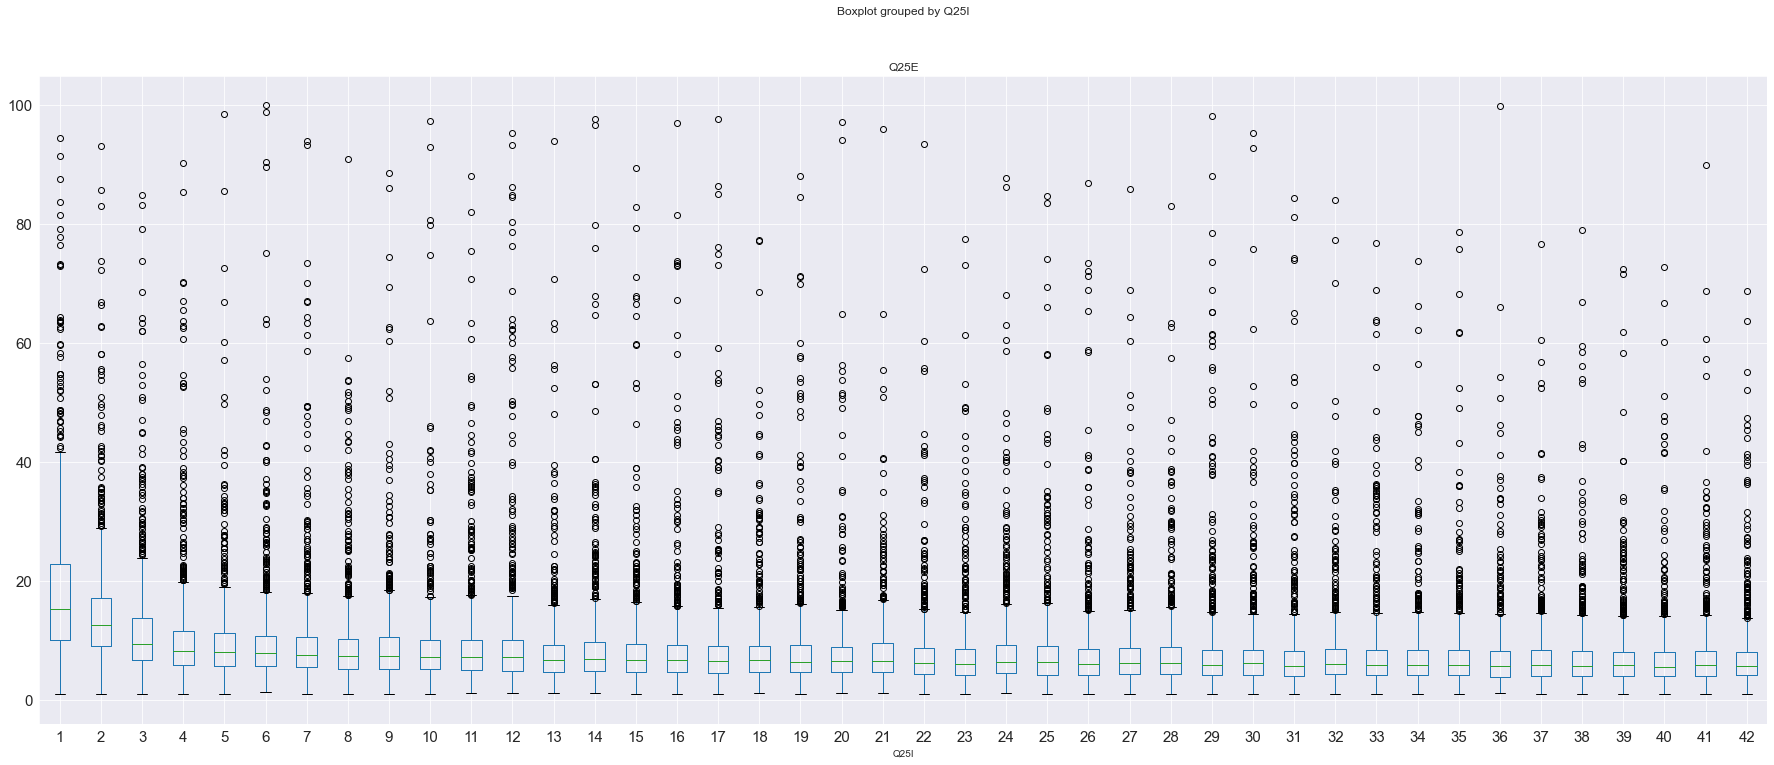

In [117]:
scale_q_data.boxplot(column='Q25E', by='Q25I',figsize=(30,12), fontsize=15)

In [84]:
np.argmin(scale_q_data[qe_names].median())+1 #36 вопрос тоже из блока про тревожность

35

<AxesSubplot:title={'center':'Q36E'}, xlabel='Q36I'>

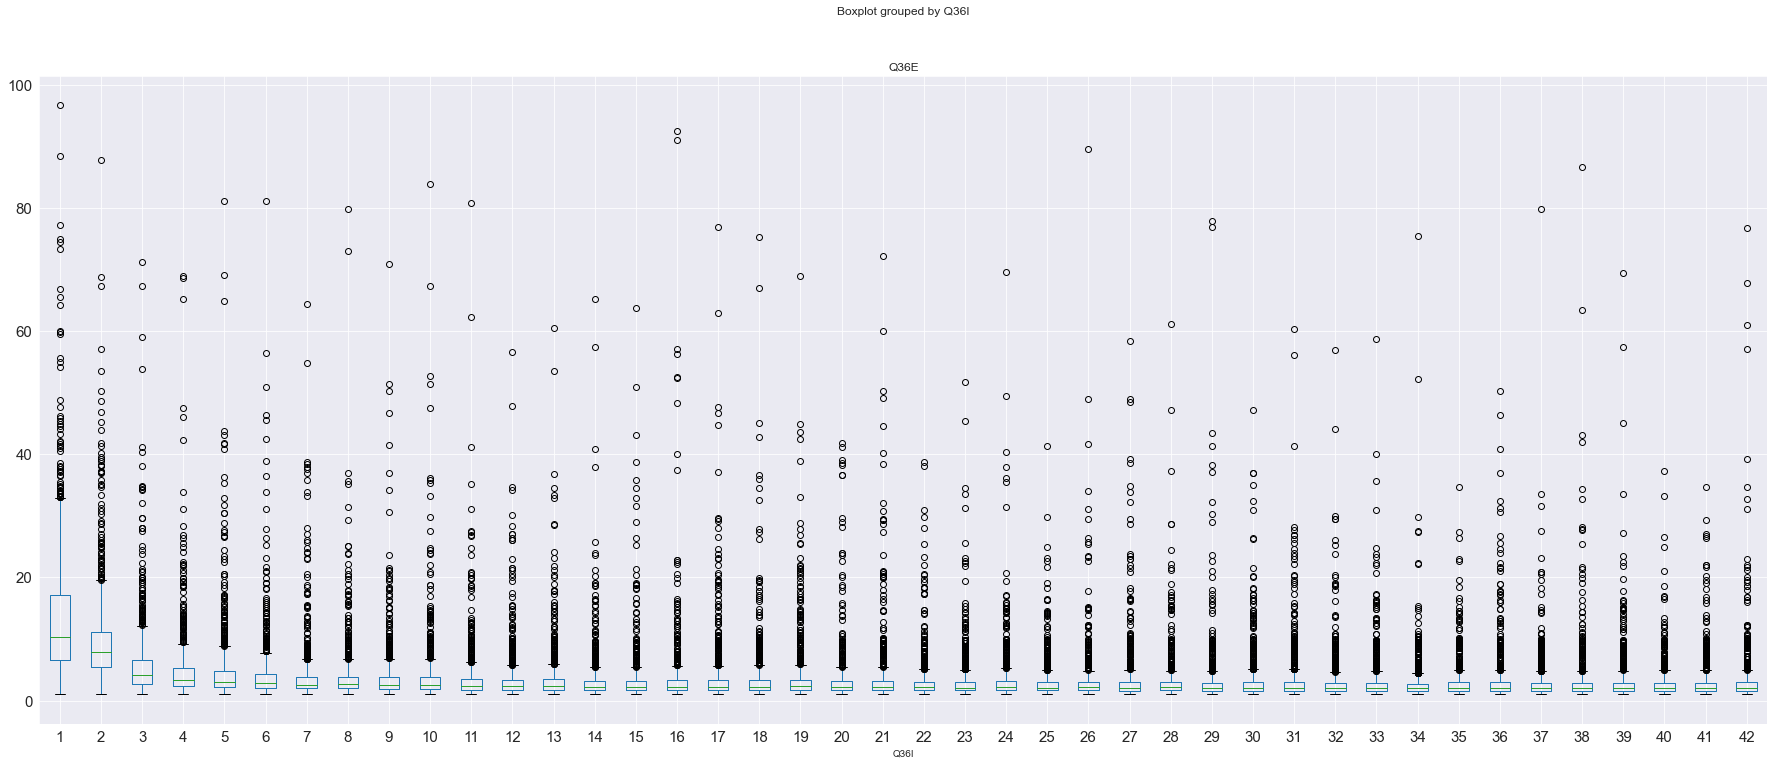

In [118]:
scale_q_data.boxplot(column='Q36E', by='Q36I',figsize=(30,12), fontsize=15)

Q25 I was aware of the action of my heart in the absence of physical exertion (eg, sense of heart rate increase, heart missing a beat)

Q36 I felt terrified

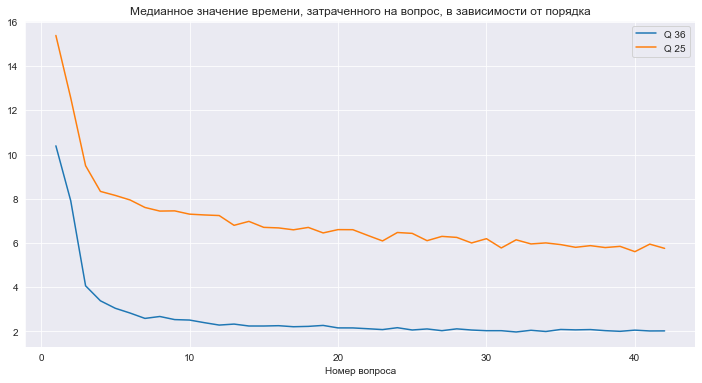

In [129]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(1,43), list(scale_q_data.groupby('Q36I')['Q36E'].median()), label='Q 36')
plt.plot(range(1,43), list(scale_q_data.groupby('Q25I')['Q25E'].median()), label='Q 25')
plt.legend()
plt.xlabel('Номер вопроса')
plt.title('Медианное значение времени, затраченного на вопрос, в зависимости от порядка')
plt.show()

На примере двух вопросов, на которые в среднем тратят наибольшее и наименьшее время, видно, что чем ближе к началу встречается вопрос, тем больше времени на него тратят

___

In [102]:
scale_q_data.groupby('Q36A')['Q36E'].median()

Q36A
1    2.134
2    2.766
3    2.463
4    1.887
Name: Q36E, dtype: float64

In [103]:
scale_q_data.groupby('Q25A')['Q25E'].median()

Q25A
1    6.5565
2    7.4640
3    6.8495
4    5.7505
Name: Q25E, dtype: float64

In [104]:
pd.pivot_table(scale_q_data, index=['depr_level', 'str_level'], values=['Q25E', 'Q36E'], aggfunc='median')

Q25E    Q36E
depr_level str_level                
0          0          6.8220  2.1680
           1          7.0590  2.5100
           2          6.7190  2.3970
           3          5.8050  2.4060
1          0          6.9465  2.3970
           1          7.2560  2.5325
           2          6.9665  2.5205
           3          6.4630  2.3260
2          0          6.5715  2.4715
           1          6.8630  2.4940
           2          6.8255  2.3775
           3          6.6475  2.2335
3          0          6.3440  2.4390
           1          6.6990  2.4670
           2          6.7350  2.2980
           3          6.0500  1.9740

Медленнее выбирают 2 вариант ответа, возможно из-за сложности оценки невыраженного состояния (возможно также что такие результаты завышены или занижены в отдельных случаях, так как кто-то боится неправильно себя оценить и приуменьшает свои проблемы, а кто-то склонен к мнительности)

___

In [107]:
scale_q_data.groupby('depr_level')[['anx_level','str_level']].describe()

anx_level                                              str_level  \
               count      mean       std  min  25%  50%  75%  max     count   
depr_level                                                                    
0            10553.0  0.462523  0.732350  0.0  0.0  0.0  1.0  3.0   10553.0   
1             9801.0  1.247220  0.948575  0.0  1.0  1.0  2.0  3.0    9801.0   
2             9941.0  1.840157  0.988007  0.0  1.0  2.0  3.0  3.0    9941.0   
3             8977.0  2.364821  0.887388  0.0  2.0  3.0  3.0  3.0    8977.0   

                                                         
                mean       std  min  25%  50%  75%  max  
depr_level                                               
0           0.417038  0.698586  0.0  0.0  0.0  1.0  3.0  
1           1.232833  0.892638  0.0  1.0  1.0  2.0  3.0  
2           1.881400  0.902443  0.0  1.0  2.0  3.0  3.0  
3           2.483458  0.782766  0.0  2.0  3.0  3.0  3.0

Чем выше уровень депрессии, тем чаще встречаются серьёзные проявления тревожности и стресса

In [130]:
scale_q_data[['depr_level','anx_level','str_level']].corr()

,depr_level,anx_level,str_level
depr_level,1.000000,0.619237,0.680725
anx_level,0.619237,1.000000,0.747659
str_level,0.680725,0.747659,1.000000


Видно, что наиболее существенная корреляция между уровнями стресса и тревоги. Между депрессией и тревожностью тоже есть корреляция, пусть и более слабая

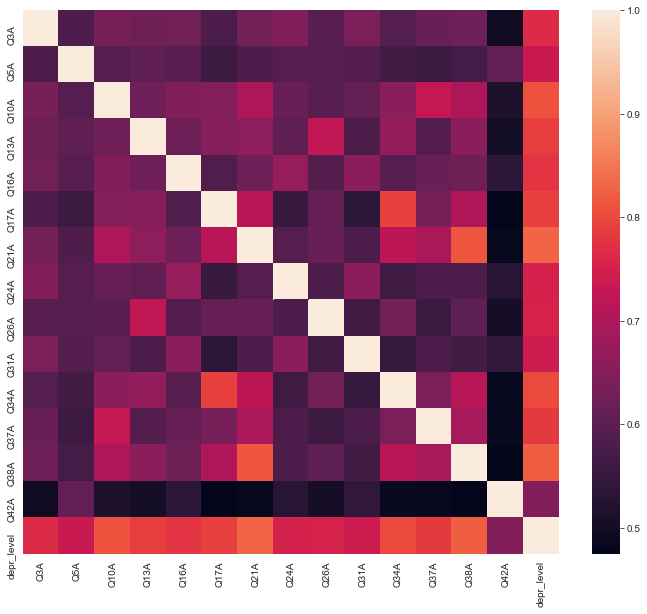

In [134]:
plt.figure(figsize=(12,10))
sns.heatmap(scale_q_data[q_depr+['depr_level']].corr())
plt.show()

Наиболее взаимосвязаны вопросы 17 и 34, 21 и 38, при этом связь вопроса 42 со всеми остальными - наименьшая.
Также наибольшая корреляция заметна между итоговым результатом и вопросами 10, 21 и 38. Ответ на 42 вопрос возможно оказывает наименьшее влияние на результат теста.

In [135]:
scale_q_data[q_depr+['depr_level']].corr()['depr_level'].sort_values()

Q42A          0.646780
Q5A           0.735018
Q31A          0.739372
Q24A          0.750481
Q26A          0.752851
Q3A           0.764733
Q16A          0.778457
Q37A          0.784188
Q13A          0.788118
Q17A          0.791406
Q34A          0.800785
Q10A          0.811211
Q38A          0.822317
Q21A          0.827988
depr_level    1.000000
Name: depr_level, dtype: float64

Так как корреляция между вопросами 21 и 38 высока, не будем рассматривать влияние вопроса 38 на результат

<AxesSubplot:xlabel='Q21A', ylabel='count'>

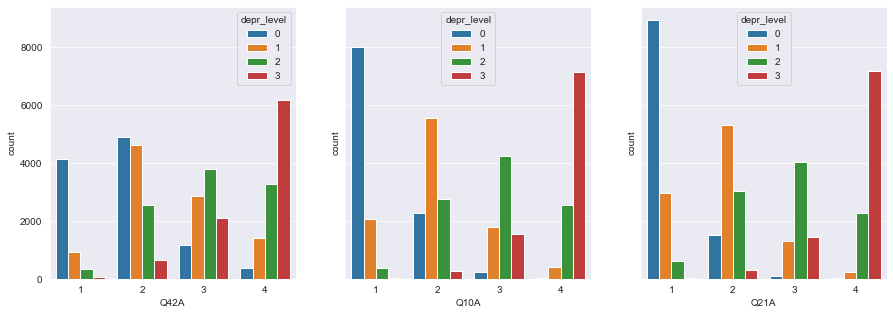

In [136]:
fig,ax=plt.subplots(1,3, figsize=(15,5), sharey=True)
sns.countplot(x=scale_q_data['Q42A'], hue=scale_q_data['depr_level'], ax=ax[0])
sns.countplot(x=scale_q_data['Q10A'], hue=scale_q_data['depr_level'], ax=ax[1])
sns.countplot(x=scale_q_data['Q21A'], hue=scale_q_data['depr_level'], ax=ax[2])

In [137]:
scale_q_data['Q42A'].value_counts(normalize=True)

2    0.323513
4    0.284936
3    0.252088
1    0.139463
Name: Q42A, dtype: float64

Вопрос 42 нельзя убрать из рассмотрения, так как в целом прослеживается связь между ответом на него и выраженностью депрессии, но стоит обратить внимание на то, что отсутствие этого симптома встречается при депрессии разной степени тяжести чаще, чем в случае с другими вопросами. 

Вопрос 42 касается способности проявлять инициативу, что зависит от многих факторов и не обязательно свидетельствует о психологических проблемах

<AxesSubplot:xlabel='str_level', ylabel='count'>

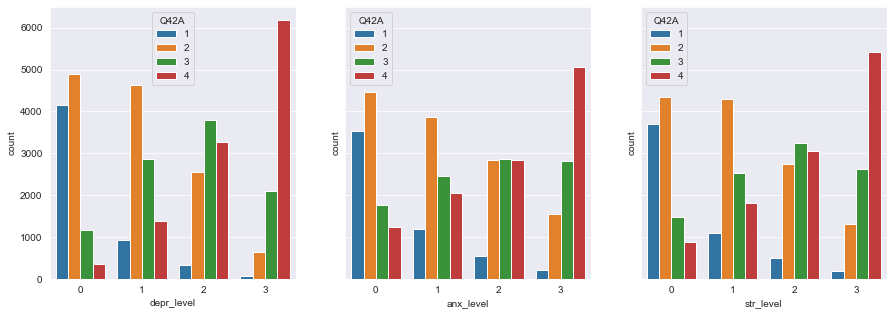

In [138]:
fig,ax=plt.subplots(1,3, figsize=(15,5), sharey=True)
sns.countplot(x=scale_q_data['depr_level'], hue=scale_q_data['Q42A'], ax=ax[0])
sns.countplot(x=scale_q_data['anx_level'], hue=scale_q_data['Q42A'], ax=ax[1])
sns.countplot(x=scale_q_data['str_level'], hue=scale_q_data['Q42A'], ax=ax[2])

Среди людей с тяжёлым течением депрессии большинство отмечает у себя серьёзные проблемы с инициативностью, для людей с высокими уровнями стресса или тревожности тоже характерна эта проблема. Однако эта проблема встречается и среди людей с низким уровнем тревоги и стресса.

___

In [151]:
freq=[]
for name in q_anx:
    freq.append(scale_q_data[scale_q_data.anx_level==3][name].value_counts(normalize=True,sort=False)[1])       
np.array(q_anx)[np.argsort(freq)[-3:]], np.array(freq)[np.argsort(freq)[-3:]]

(array(['Q19A', 'Q15A', 'Q23A'], dtype='<U4'),
 array([0.11063874, 0.1110535 , 0.22666943]))

Люди с выраженной тревожностью иногда отмечают у себя отсутствие некоторых симптомов, особенно часто это происходит для вопросов 19, 15, 23:

Q15	I had a feeling of faintness (11% участников с высокой тревожностью)

Q19	I perspired noticeably (eg, hands sweaty) in the absence of high temperatures or physical exertion (11% участников с высокой тревожностью)

Q23	I had difficulty in swallowing (22% участников с высокой тревожностью)

В основном это физические проявления тревоги

In [157]:
freq=[]
for name in q_anx:
    freq.append(scale_q_data[scale_q_data.anx_level==3][name].value_counts(normalize=True,sort=False)[4])       
np.array(q_anx)[np.argsort(freq)[-3:]], np.array(freq)[np.argsort(freq)[-3:]]

(array(['Q20A', 'Q9A', 'Q40A'], dtype='<U4'),
 array([0.59695147, 0.68851099, 0.71443384]))

При этом наиболее распространённые симптомы тревожности сильной выраженности:

Q9	I found myself in situations that made me so anxious I was most relieved when they ended

Q20	I felt scared without any good reason

Q40	I was worried about situations in which I might panic and make a fool of myself

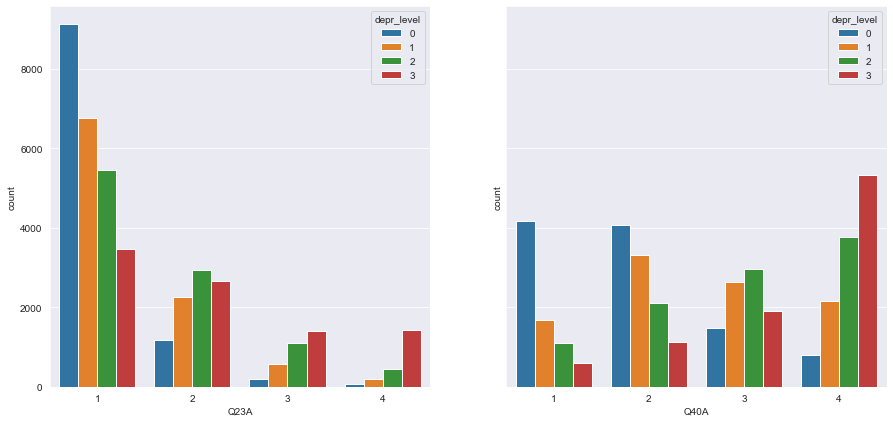

In [159]:
fig, ax=plt.subplots(1,2, figsize=(15,7), sharey=True)
j=0
names4=['Q23A', 'Q40A']
for name in names4:
    sns.countplot(x=scale_q_data[name], ax=ax[j], hue=scale_q_data['depr_level'])
    j+=1

Хотя есть связь между симптомом 23 и выраженностью депрессии (большинство людей с заметным проявлением этого симптома в целом имеют высокий уровень депрессии), большинство людей не замечают его у себя независимо от уровня депрессии.

### Анализ теста VCL

Слова, предложенные в вопросах 6, 9, 12 - несуществующие, поэтому меняем ответы на противоположные

In [160]:
scale_v_data['VCL6']=scale_v_data['VCL6'].replace({0:1, 1:0})
scale_v_data['VCL9']=scale_v_data['VCL9'].replace({0:1, 1:0})
scale_v_data['VCL12']=scale_v_data['VCL12'].replace({0:1, 1:0})

In [161]:
res=scale_v_data.sum(axis=1)
res.name='result'
scale_v_data=pd.concat([scale_v_data, res], axis=1)

,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16,result
count,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000
mean,0.816409,0.584921,0.153774,0.871002,0.690466,0.959539,0.084157,0.170554,0.956610,0.874745,0.074430,0.915079,0.294205,0.570483,0.851548,0.935246,9.803168
std,0.387156,0.492742,0.360736,0.335202,0.462307,0.197041,0.277626,0.376124,0.203735,0.331012,0.262472,0.278767,0.455690,0.495014,0.355552,0.246094,2.702549
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000


In [162]:
res2=scale_v_data['result'].apply(levels, arr=list(res.describe()[4:]))
res2.name='level_v'
scale_v_data=pd.concat([scale_v_data,res2], axis=1)
scale_v_data.head()

,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16,result,level_v
0,1,0,0,1,1,1,1,0,1,1,0,1,0,1,1,1,11,2
1,1,1,0,1,1,1,0,0,1,1,0,1,0,1,1,1,11,2
2,1,0,0,1,1,1,0,0,1,0,1,1,0,1,1,1,10,1
3,1,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,10,1
4,1,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,13,3


#### Проверим, какие слова вызывают наибольшее/наименьшее затруднение

In [163]:
scale_v_data.corr().unstack()['result'].abs().sort_values()

VCL9       0.011442
VCL6       0.067652
VCL12      0.108715
VCL7       0.305364
VCL11      0.333470
VCL8       0.418235
VCL16      0.447174
VCL3       0.499135
VCL10      0.569151
VCL15      0.609547
VCL4       0.610190
VCL13      0.625666
VCL1       0.642739
VCL5       0.675695
VCL14      0.676572
VCL2       0.685764
level_v    0.920333
result     1.000000
dtype: float64

Результат зависит в основном от слов 2,5,14

При этом не особо зависит от 6,9,12, которые являются выдуманными

<AxesSubplot:xlabel='VCL12', ylabel='count'>

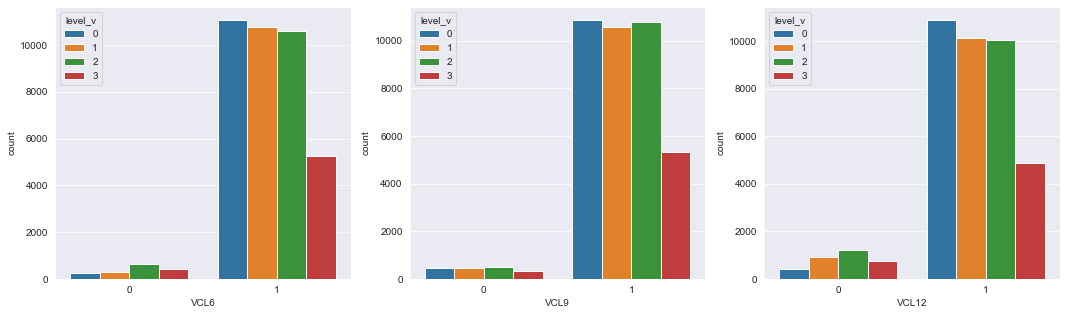

In [164]:
fig, ax=plt.subplots(1,3, figsize=(18,5))
sns.countplot(x=scale_v_data['VCL6'],hue=scale_v_data['level_v'], ax=ax[0])
sns.countplot(x=scale_v_data['VCL9'],hue=scale_v_data['level_v'], ax=ax[1])
sns.countplot(x=scale_v_data['VCL12'],hue=scale_v_data['level_v'], ax=ax[2])

Предложенные в данном случае слова - cuivocal, florted, verdid

Большинство людей правильно отметили, что не знают эти слова

<AxesSubplot:xlabel='VCL5', ylabel='count'>

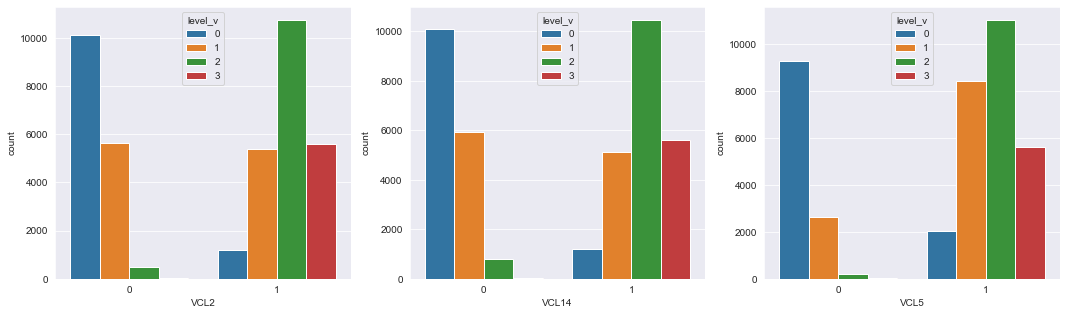

In [165]:
fig, ax=plt.subplots(1,3, figsize=(18,5))
sns.countplot(x=scale_v_data['VCL2'],hue=scale_v_data['level_v'], ax=ax[0])
sns.countplot(x=scale_v_data['VCL14'],hue=scale_v_data['level_v'], ax=ax[1])
sns.countplot(x=scale_v_data['VCL5'],hue=scale_v_data['level_v'], ax=ax[2])

Проверим, как отвечают на наиболее решающие вопросы те, кто якобы знают слова из вопросов 6,9,12

In [166]:
mask=((scale_v_data['VCL6']==0)|(scale_v_data['VCL9']==0)|(scale_v_data['VCL12']==0))

<AxesSubplot:xlabel='VCL5', ylabel='count'>

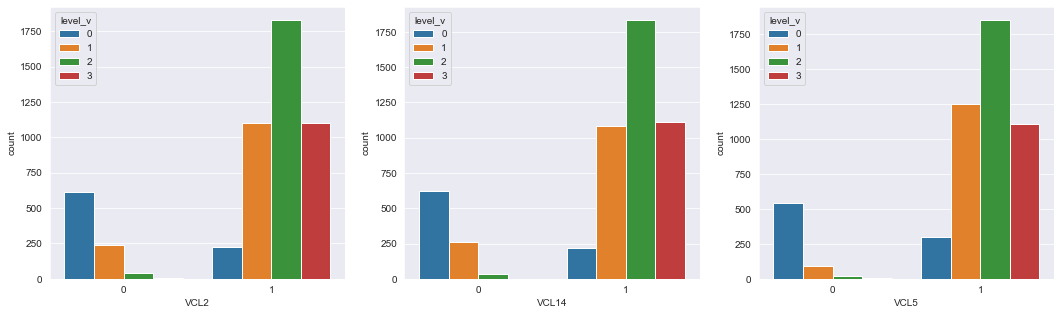

In [167]:
fig, ax=plt.subplots(1,3, figsize=(18,5))
sns.countplot(x=scale_v_data.loc[mask,'VCL2'],hue=scale_v_data.loc[mask,'level_v'], ax=ax[0])
sns.countplot(x=scale_v_data.loc[mask,'VCL14'],hue=scale_v_data.loc[mask,'level_v'], ax=ax[1])
sns.countplot(x=scale_v_data.loc[mask,'VCL5'],hue=scale_v_data.loc[mask,'level_v'], ax=ax[2])

Примерно каждый пятый из тех, кто правильно ответил на вопросы 2, 5, 14, ошибались в вопросах 6, 9, 12, то есть скорее всего отвечали наугад или привирали. 

При этом те, кто ошибся в словах 2, 5, 14 чаще правильно указывали незнание слов 6, 9, 12

### Анализ участников тестирования

Объединим персональные данные участников и их результаты тестов

In [168]:
personal_info=personal_info.merge(scale_v_data['level_v'], left_index=True,right_index=True)

In [169]:
personal_info=personal_info.merge(data_tech['country'], left_index=True,right_index=True)

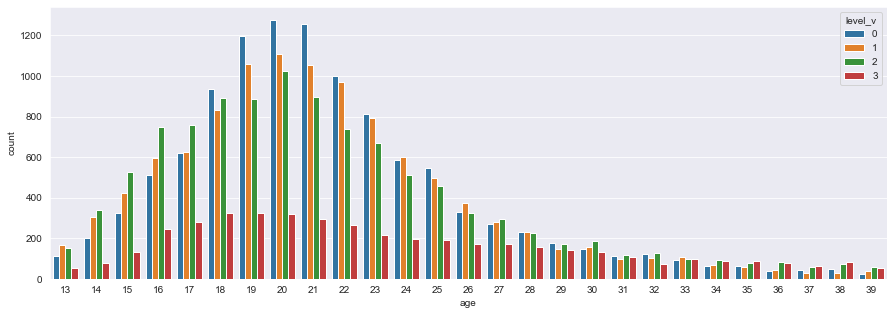

In [180]:
fig=plt.figure(figsize=(15,5))
sns.countplot(x=personal_info[personal_info['age']<40]['age'], hue=personal_info['level_v'])
plt.show()

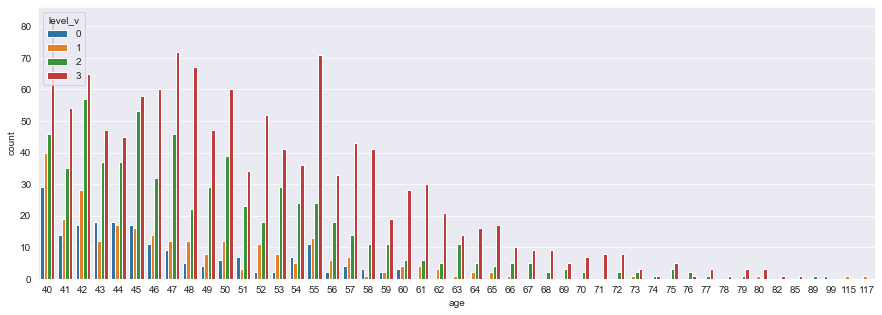

In [179]:
fig=plt.figure(figsize=(15,5))
sns.countplot(x=personal_info[personal_info['age']>=40]['age'], hue=personal_info['level_v'])
plt.show()

С возрастом доля "грамотных" увеличивается

In [172]:
personal_info[personal_info['age']>=40]['level_v'].value_counts(normalize=True)

3    0.521169
2    0.284505
1    0.113040
0    0.081287
Name: level_v, dtype: float64

In [173]:
personal_info[personal_info['age']<40]['level_v'].value_counts(normalize=True)

0    0.301463
1    0.292333
2    0.286670
3    0.119534
Name: level_v, dtype: float64

In [174]:
personal_info=personal_info.merge(scale_q_data['depr_level'], left_index=True,right_index=True)
personal_info=personal_info.merge(scale_q_data['anx_level'], left_index=True,right_index=True)
personal_info=personal_info.merge(scale_q_data['str_level'], left_index=True,right_index=True)

In [175]:
personal_info=personal_info.merge(file1[['Extraversion', 'Agreeableness','Conscientiousness',\
                                                   'Em_stability','Openness']], left_index=True,right_index=True)


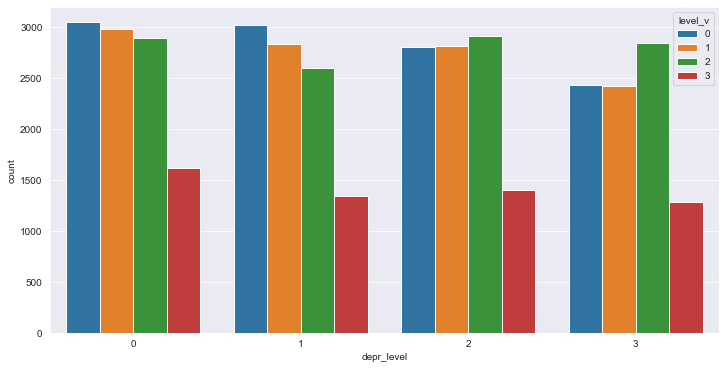

In [178]:
plt.figure(figsize=(12,6))
sns.countplot(x=personal_info['depr_level'], hue=personal_info['level_v'])
plt.show()

Количество людей с разным результатом теста VCL примерно одинаково в независимости от выраженности депрессивности

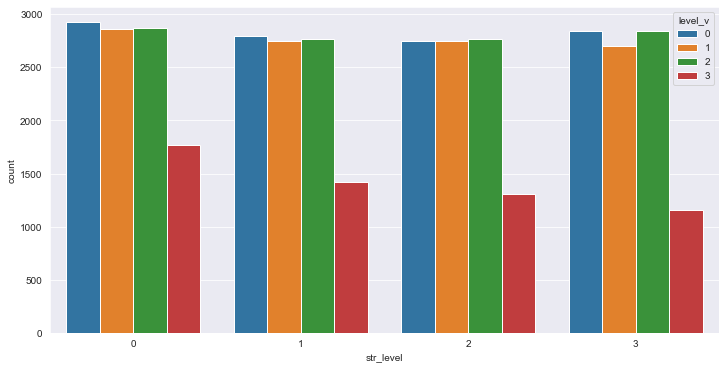

In [182]:
plt.figure(figsize=(12,6))
sns.countplot(x=personal_info['str_level'], hue=personal_info['level_v'])
plt.show()

С повышением уровня стресса доля наиболее грамотных уменьшается, остальных количество примерно одинаковое вне зависимости от количества стресса 

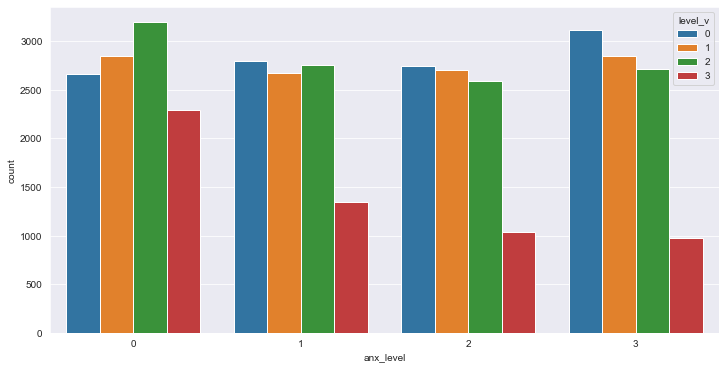

In [183]:
plt.figure(figsize=(12,6))
sns.countplot(x=personal_info['anx_level'], hue=personal_info['level_v'])
plt.show()

Тенденция, обозначенная для уровня стресса, сохраняется в более выраженном виде и для тревожности, при этом при высоком уровне тревожности - наибольшее число "малограмотных".

___

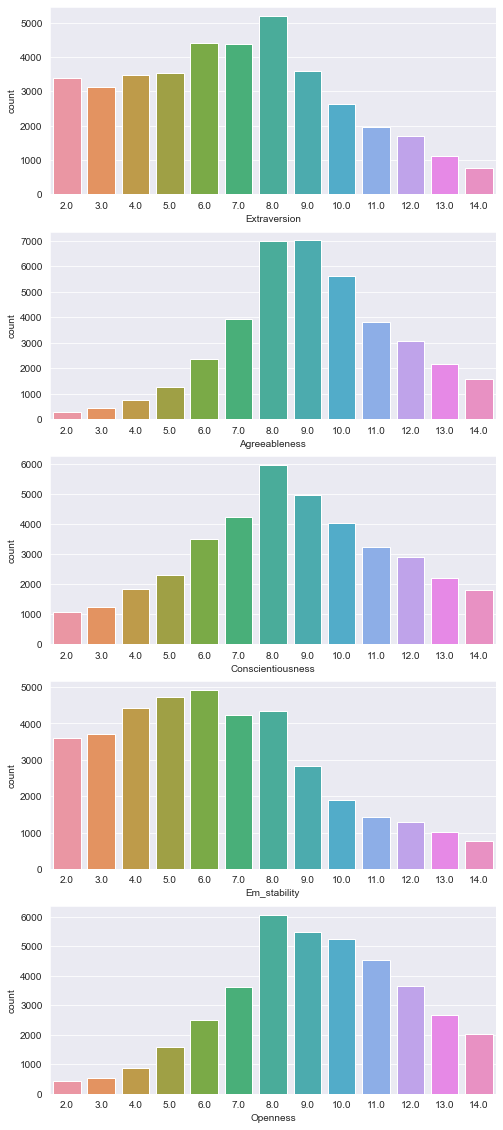

In [185]:
quality_names=['Extraversion', 'Agreeableness','Conscientiousness','Em_stability','Openness']
fig, ax=plt.subplots(5,1,figsize=(8,20))
i=0
for name in quality_names:
    sns.countplot(x=personal_info[name], ax=ax[i])
    i+=1

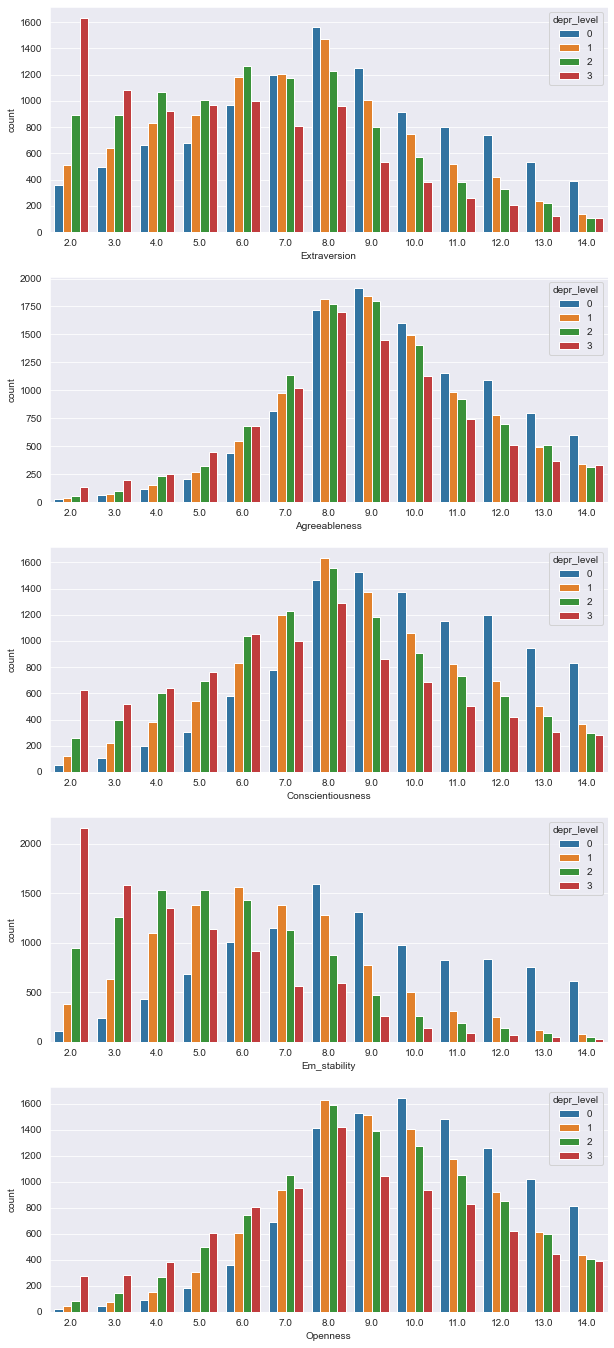

In [187]:
fig, ax=plt.subplots(5,1,figsize=(10,24))
for i in range(5):
    sns.countplot(x=personal_info[quality_names[i]], hue=personal_info['depr_level'], ax=ax[i])

В целом видно, что люди, оценивающие себя как замкнутые, эмоционально не стабильные, более склонны иметь выраженную депрессию

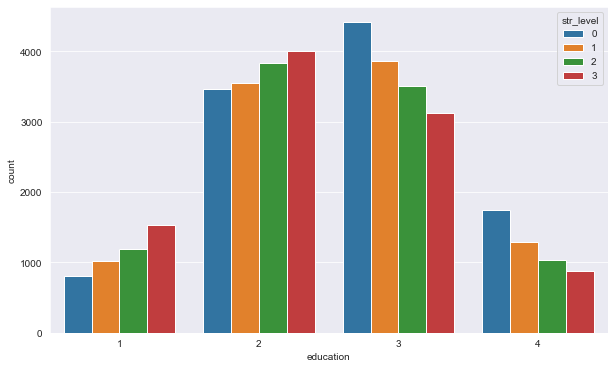

In [224]:
fig=plt.figure(figsize=(10,6))
sns.countplot(x=personal_info['education'], hue=personal_info['str_level'])
plt.show()

<AxesSubplot:xlabel='education', ylabel='count'>

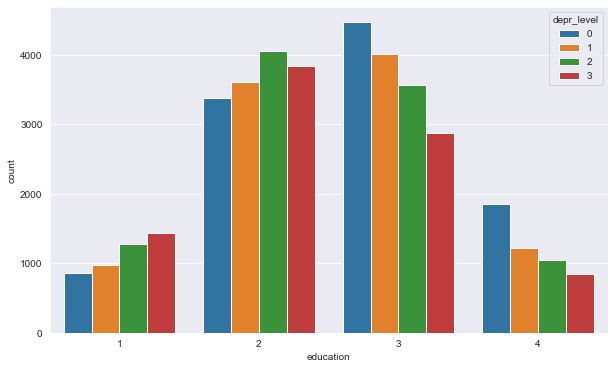

In [190]:
plt.figure(figsize=(10,6))
sns.countplot(x=personal_info['education'], hue=personal_info['depr_level'])

Среди людей с школьным образованием и ниже чаще встречаются проблемы с депрессией и повышенным стрессом, чем среди людей с высшим образованием.

In [191]:
personal_info[personal_info['education']==1]['age'].describe()

count    4541.000000
mean       17.403435
std         6.913227
min        13.000000
25%        15.000000
50%        16.000000
75%        17.000000
max       115.000000
Name: age, dtype: float64

В основном люди, не окончившие старшую школу - школьники, часть из которых её не поступала туда(наверное)

In [192]:
personal_info[personal_info['education']==2]['age'].describe()

count    14865.000000
mean        21.316112
std          7.766124
min         13.000000
25%         18.000000
50%         19.000000
75%         21.000000
max        117.000000
Name: age, dtype: float64

В основном люди, окончившие только старшую школу, по возрасту подходят под студентов

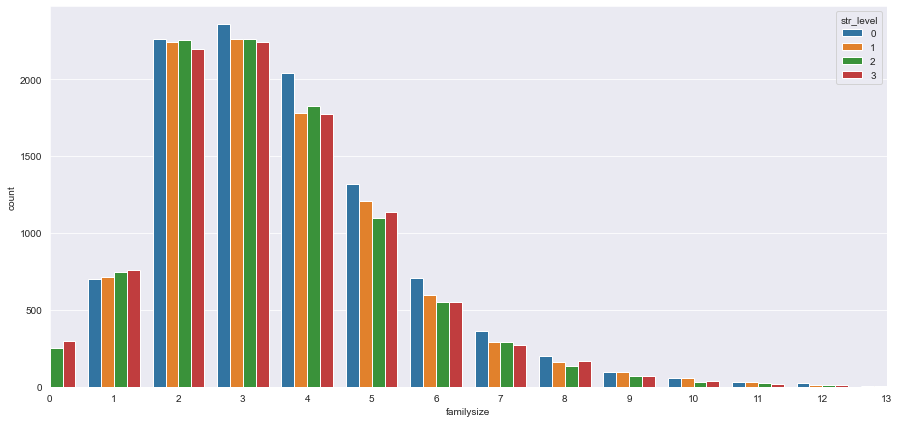

In [205]:
fig=plt.figure(figsize=(15,7))
sns.countplot(x=personal_info['familysize'], hue=personal_info['str_level'])
plt.xlim([0,13])
plt.show()

С увеличением количества детей в семье доля сильного стресса уменьшается

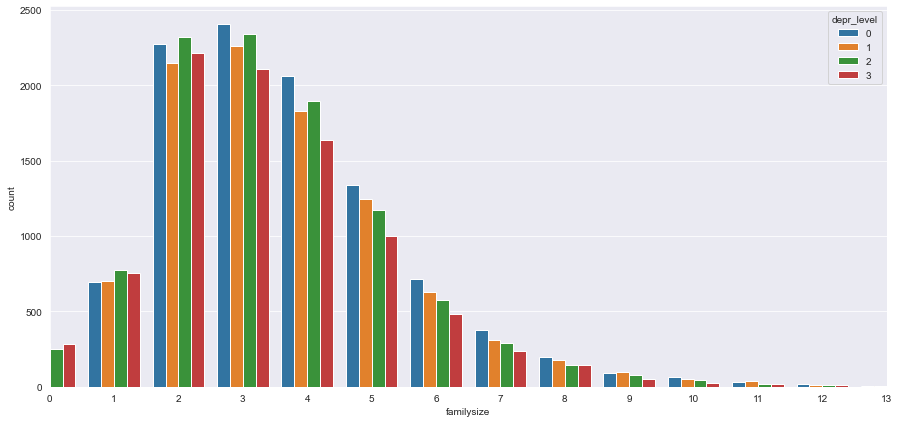

In [206]:
fig=plt.figure(figsize=(15,7))
sns.countplot(x=personal_info['familysize'], hue=personal_info['depr_level'])
plt.xlim([0,13])
plt.show()

С увеличением количества детей в семье (больше 3-х) доля тяжёлой депрессии уменьшается

___

### Рассмотрим, как себя ведут группы похожих испытуемых

In [209]:
group1=((personal_info.age<20)&(personal_info.education==1)&(personal_info.urban==3)&(personal_info.gender==1))
group2=((personal_info.age<20)&(personal_info.education==1)&(personal_info.urban==3)&(personal_info.gender==2))

In [210]:
group3=((personal_info.age<20)&(personal_info.education==1)&(personal_info.urban==1)&(personal_info.gender==1))
group4=((personal_info.age<20)&(personal_info.education==1)&(personal_info.urban==1)&(personal_info.gender==2))

Text(0.5, 1.0, 'Female, country')

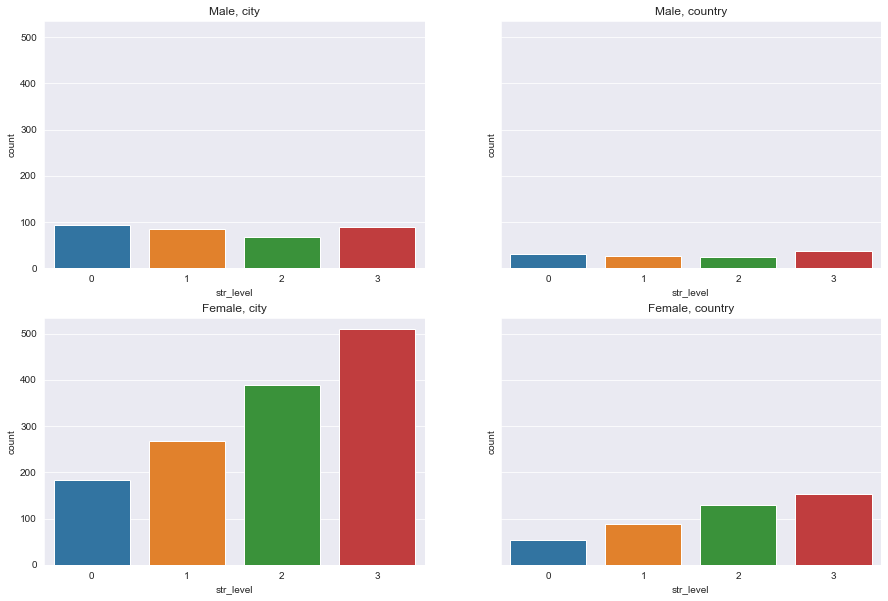

In [211]:
fig,ax=plt.subplots(2,2,figsize=(15,10), sharey=True)
test='str_level'
sns.countplot(data=personal_info.loc[group1, :], x=test, ax=ax[0,0])
ax[0,0].set_title('Male, city')
sns.countplot(data=personal_info.loc[group2, :], x=test, ax=ax[1,0])
ax[1,0].set_title('Female, city')
sns.countplot(data=personal_info.loc[group3, :], x=test, ax=ax[0,1])
ax[0,1].set_title('Male, country')
sns.countplot(data=personal_info.loc[group4, :], x=test, ax=ax[1,1])
ax[1,1].set_title('Female, country')

**Люди моложе 20, имеющие основное общее образование**

У мужчин, в независимости от места рождения, примерно одинаково часто встречаются разные уровни стресса

У женщин высокий уровень стресса встречается более чем в 2 раза чаще, чем отсутствие стресса

In [212]:
group1=((personal_info.age<20)&(personal_info.education==2)&(personal_info.urban==3)&(personal_info.gender==1))
group2=((personal_info.age<20)&(personal_info.education==2)&(personal_info.urban==3)&(personal_info.gender==2))
group3=((personal_info.age<20)&(personal_info.education==2)&(personal_info.urban==1)&(personal_info.gender==1))
group4=((personal_info.age<20)&(personal_info.education==2)&(personal_info.urban==1)&(personal_info.gender==2))

Text(0.5, 1.0, 'Female, country')

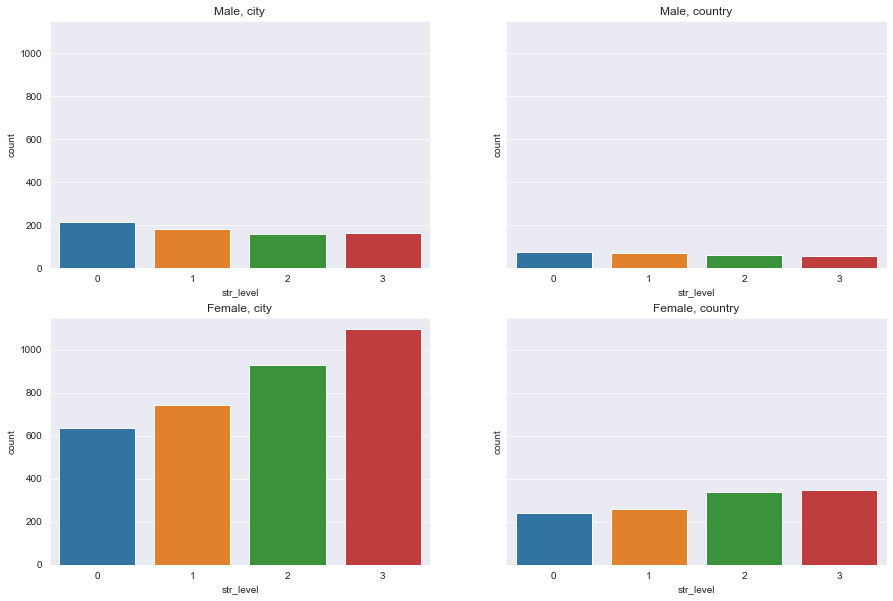

In [213]:
fig,ax=plt.subplots(2,2,figsize=(15,10), sharey=True)
test='str_level'
sns.countplot(data=personal_info.loc[group1, :], x=test, ax=ax[0,0])
ax[0,0].set_title('Male, city')
sns.countplot(data=personal_info.loc[group2, :], x=test, ax=ax[1,0])
ax[1,0].set_title('Female, city')
sns.countplot(data=personal_info.loc[group3, :], x=test, ax=ax[0,1])
ax[0,1].set_title('Male, country')
sns.countplot(data=personal_info.loc[group4, :], x=test, ax=ax[1,1])
ax[1,1].set_title('Female, country')

**Люди моложе 20, имеющие среднее общее образование**

Ситуация аналогична предыдущей

In [216]:
group1=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education<3)&\
        (personal_info.urban==3)&(personal_info.gender==1))
group2=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education<3)&\
        (personal_info.urban==3)&(personal_info.gender==2))
group3=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education<3)&\
        (personal_info.urban==1)&(personal_info.gender==1))
group4=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education<3)& \
        (personal_info.urban==1)&(personal_info.gender==2))

Text(0.5, 1.0, 'Female, country')

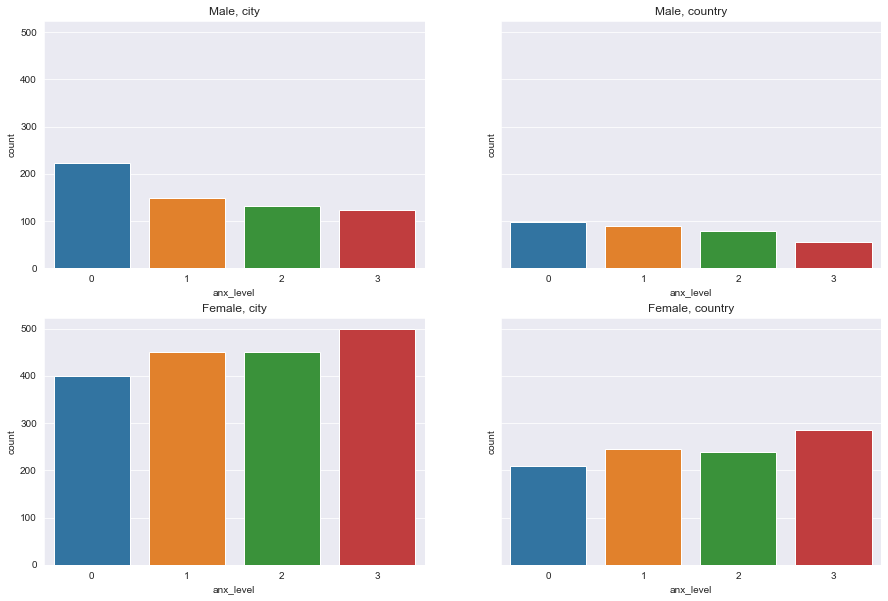

In [217]:
fig,ax=plt.subplots(2,2,figsize=(15,10), sharey=True)
test='anx_level'
sns.countplot(data=personal_info.loc[group1, :], x=test, ax=ax[0,0])
ax[0,0].set_title('Male, city')
sns.countplot(data=personal_info.loc[group2, :], x=test, ax=ax[1,0])
ax[1,0].set_title('Female, city')
sns.countplot(data=personal_info.loc[group3, :], x=test, ax=ax[0,1])
ax[0,1].set_title('Male, country')
sns.countplot(data=personal_info.loc[group4, :], x=test, ax=ax[1,1])
ax[1,1].set_title('Female, country')

**Люди от 20 до 30, не имеющие высшее образование**

У мужчин чаще нет тревоги или её уровень низок

У женщин доля высокой тревожности больше, чем низкой, но разрыв не так существеннен

In [218]:
group1=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education<3)&\
        (personal_info.gender==1))
group2=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education<3)&\
        (personal_info.gender==2))
group3=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education>2)&\
        (personal_info.gender==1))
group4=((personal_info.age>=20)&(personal_info.age<30)&(personal_info.education>2)& \
        (personal_info.gender==2))

Text(0.5, 1.0, 'Female, univercity')

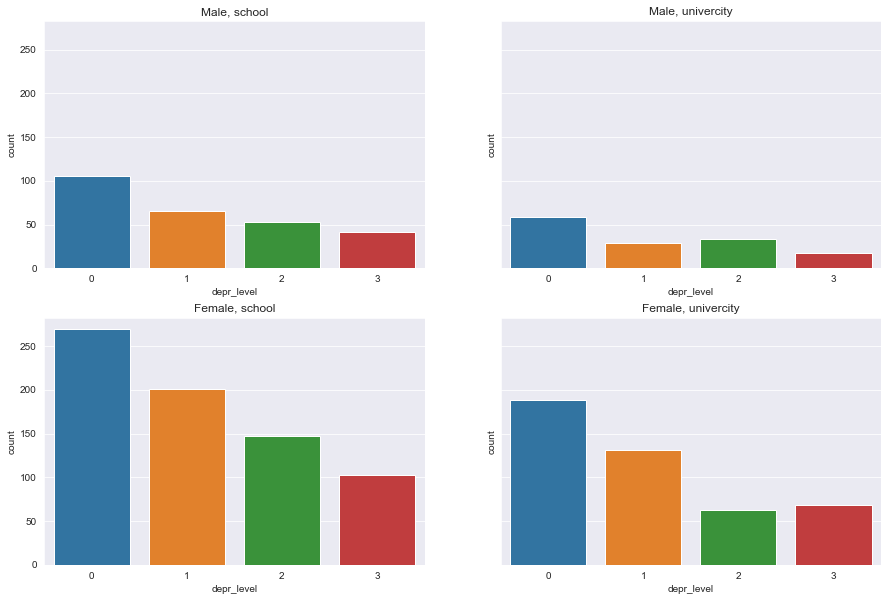

In [220]:
fig,ax=plt.subplots(2,2,figsize=(15,10), sharey=True)
test='depr_level'
sns.countplot(data=personal_info.loc[group1, :], x=test, ax=ax[0,0])
ax[0,0].set_title('Male, school')
sns.countplot(data=personal_info.loc[group2, :], x=test, ax=ax[1,0])
ax[1,0].set_title('Female, school')
sns.countplot(data=personal_info.loc[group3, :], x=test, ax=ax[0,1])
ax[0,1].set_title('Male, univercity')
sns.countplot(data=personal_info.loc[group4, :], x=test, ax=ax[1,1])
ax[1,1].set_title('Female, univercity')

**Люди от 20 до 30 с и без высшего образования**

Разная выраженность депрессии встречается примерно одинаково для мужчин и женщин с разным уровнем образования